# Otimizações de grão fino (SIMD)

A seguir vamos examinar a CPU disponível, seu conjunto de instruções e a capacidade do GCC para gerar código usando estas instruções. 

In [99]:
#CPU flag detection
!echo "*** Getting CPU flag capabilities and number of cores"
!cat /proc/cpuinfo  | egrep "(flags|model name)" | sort | uniq -c
#Compiler capabilities. -march=native is required!
!echo "*** Getting GCC capabilities"
!gcc -march=native -dM -E - < /dev/null | egrep "SSE|AVX" | sort 

*** Getting CPU flag capabilities and number of cores
     24 flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 cdp_l3 invpcid_single pti ssbd mba ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm cqm mpx rdt_a avx512f avx512dq rdseed adx smap clflushopt clwb intel_pt avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves cqm_llc cqm_occup_llc cqm_mbm_total cqm_mbm_local dtherm ida arat pln pts hwp hwp_act_window hwp_epp hwp_pkg_req pku ospke md_clear flush_l1d
     24 model name	: Intel(R) Xeon(R) Go

In [142]:
%%writefile lab/autovector.cpp
#pragma GCC optimize("O3")
#pragma GCC optimize("unroll-loops","omit-frame-pointer","inline")
#pragma GCC option("arch=native","tune=native","no-zero-upper")
#pragma GCC target("avx512f")
#include <x86intrin.h>
#include <bits/stdc++.h>

using namespace std;
using namespace std::chrono;

int main()
{
	const int N = 200000; //Array Size
	const int noTests = 10000; //Number of tests
	float a[N],b[N],c[N],result[N];
    auto now = high_resolution_clock::now();
    for (int i = 0; i < N; ++i)  //Data initialization
	{ 
      a[i] =       ((float)i)+ 0.1335f; 
	  b[i] = 1.50f*((float)i)+ 0.9383f; 
	  c[i] = 0.33f*((float)i)+ 0.1172f; 
    }    
   for (int i = 0; i < noTests; ++i) 
	 for (int j = 0; j < N; ++j)
	 {
	  result[j] = a[j]+b[j]-c[j]+3*(float)i;
	 }
	auto end_time = duration_cast<duration<double>>(high_resolution_clock::now() - now).count();
	assert( result[2] == ( 2.0f + 0.1335f)+( 1.50f*2.0f + 0.9383f)-(0.33f*2.0f+0.1172f)+3*(float)(noTests-1));
    cout << "Time used: "<< end_time << "s, N * noTests="<<(N*noTests)<< endl;
    return 0;
}

Overwriting lab/autovector.cpp


In [143]:
!g++ -S lab/autovector.cpp -fverbose-asm

In [144]:
!g++ -o bin/autovector lab/autovector.cpp && bin/autovector

Time used: 0.200524s, N * noTests=2000000000


In [145]:
!dpcpp -S lab/autovector.cpp -fverbose-asm

In [146]:
!dpcpp -o bin/autovector lab/autovector.cpp && bin/autovector

autovector: lab/autovector.cpp:29: int main(): Assertion `result[2] == ( 2.0f + 0.1335f)+( 1.50f*2.0f + 0.9383f)-(0.33f*2.0f+0.1172f)+3*(float)(noTests-1)' failed.


,versão,tempo_de_execução_s
0,naive,4.318750
1,o3,1.090910
2,unroll,0.208338
3,avx512f,0.197168


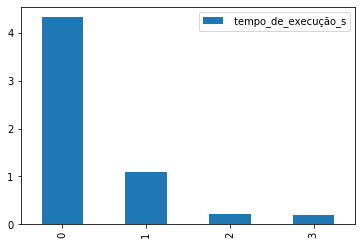

In [147]:
import pandas as pd
import numpy

df = pd.read_csv('data.csv')
plt = df.plot(kind="bar")
df

## Referências
- https://www.oneapi.io/
- https://tech.io/playgrounds/53858/vetorizacao-sse-avx/